In [1]:
# News Category Dataset
# https://www.kaggle.com/datasets/rmisra/news-category-dataset
# ここからデータセットをダウンロードすると、archive.zipがダウンロードされる
# それをnews_category_dataset_kaggle.zipとしてMyDriveに保存
!ls /content/drive/MyDrive/ | grep news
!cp /content/drive/MyDrive/news_category_dataset_kaggle.zip .
!unzip news_category_dataset_kaggle.zip

news_category_dataset_kaggle.zip
Archive:  news_category_dataset_kaggle.zip
  inflating: News_Category_Dataset_v3.json  


In [2]:
# データセットの読み込み
data_list = []
# ファイルを開く
with open('/content/News_Category_Dataset_v3.json', 'r') as file:
    # ファイルの各行に対してループ処理
    for line in file:
        # lineから改行を排除し、str -> dict 変換
        line = eval(line.replace("\n", ""))
        # テキスト配列に、ニュースの見出しと概要を連結した文章を追加
        data_list.append({
            "text": line["headline"] + " " + line["short_description"],
            "category": line["category"],
        })
print(data_list[:10])
print(str(len(data_list)) + " documents were loaded.")

[{'text': 'Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.', 'category': 'U.S. NEWS'}, {'text': "American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.", 'category': 'U.S. NEWS'}, {'text': '23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23) "Until you have a dog you don\'t understand what could be eaten."', 'category': 'COMEDY'}, {'text': 'The Funniest Tweets From Parents This Week (Sept. 17-23) "Accidentally put grown-up toothpaste on my toddler’s toothbrush and he screamed like I was cleaning his teeth with a Carolina Reaper dipped in Tabasco sauce."', 'category': 'PARENTING'}, {'text': 'Woman

In [3]:
!pip install nltk
import nltk
from nltk.corpus import wordnet as wn #lemmatize関数のためのimport
nltk.download('stopwords')
nltk.download('wordnet')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# 前処理
import re
# 前処理関数作成
def preprocess_word(word, stopwordset):
    
    #1.make words lower ex: Python =>python
    word=word.lower()
    
    #2.remove "," and "."
    if word in [",","."]:
        return None
    word = re.sub(r'[.,!?\'"(){}[\]:’‘“”#*]', "", word)
    
    #3.remove stopword  ex: the => (None) 
    if word in stopwordset:
        return None
    
    #4.lemmatize  ex: cooked=>cook
    lemma = wn.morphy(word)
    if lemma is None:
        return word

    elif lemma in stopwordset: #lemmatizeしたものがstopwordである可能性がある
        return None
    else:
        return lemma

def preprocess_document(document, en_stop):
    # ここではサンプルコードと違い、documentは文章 -> 単語分割する必要あり
    split_doc = document["text"].split(" ")
    processed=[preprocess_word(w, en_stop) for w in split_doc]
    # None除去
    processed=[w for w in processed if w is not None]
    # ストップワードしか含まれていないデータを除去
    pre_doc = " ".join(processed)
    if pre_doc == "":
        return None
    else:
        ret_doc = {
            "text": pre_doc,
            "category": document["category"]
        }
        return ret_doc

def preprocess_documents(documents, en_stop):
    result_list = []
    for document in documents:
        pre_doc = preprocess_document(document, en_stop) 
        if pre_doc is not None:
            result_list.append(pre_doc)
    return result_list

# stop word list 作成
# ntlk + simbols
en_stop = nltk.corpus.stopwords.words('english')
en_stop= ["``","/",",.",".,",";","--",":",")","(",'"','&',"'",'),',',"','-','.,','.,"','.-',"?",">","<"]            \
         +en_stop

# 前処理をtext_listの文章に対して実行
preprocessed_data = preprocess_documents(data_list, en_stop)
print(preprocessed_data[:2])
print(len(preprocessed_data))

[{'text': '4 million american roll sleeve omicron-targeted covid booster health expert say early predict whether demand would match 171 million dose new booster us order fall', 'category': 'U.S. NEWS'}, {'text': 'american airline flyer charge ban life punch flight attendant video subdue passenger crew flee back aircraft confrontation accord us attorney office los angeles', 'category': 'U.S. NEWS'}]
209521


In [5]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# ベクトル化

# TF/IDF
from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf_vectorizer = TfidfVectorizer(max_features=200, token_pattern=u'(?u)\b\w+\b' )
tfidf_vectorizer = TfidfVectorizer()
tf_idf = tfidf_vectorizer.fit_transform(
    [doc["text"] for doc in preprocessed_data]
)



# BoW
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer()
bow = bow_vectorizer.fit_transform(
    [doc["text"] for doc in preprocessed_data]
)



In [7]:
# Doc2Vec
# documentの単語の埋め込み表現をWord2Vecで取得し、その平均をdocument embeddingとみなす
# Word2Vec 学習済みモデルは、gensim-dataの'glove-wiki-gigaword-50'を使う（軽いので）
from gensim.models import Word2Vec
import gensim.downloader as api
import numpy as np

w2v_vectorizer = api.load("glove-wiki-gigaword-50")

In [8]:
d2v = []
def d2v_vectorize(preprocessed_data):
    for i, doc in enumerate(preprocessed_data):
        word_vecs = []
        for word in doc["text"].split(" "):
            # wordをvecに変換
            # もしwordが未知語だったら、飛ばす
            try:
                word_vecs.append(w2v_vectorizer[word])

            except: 
                # print("unknown word", word)
                pass
        
        # unknow word だけのdocumentを弾く
        if len(word_vecs) == 0:
            d2v.append(np.zeros(50))
        else:
            d2v.append(np.average(np.array(word_vecs), axis=0))
    return np.array(d2v)

d2v = d2v_vectorize(preprocessed_data)

In [9]:
# # 類似度を求める
# # 今回は、POLITICカテゴリから2文、ENTERTAINMENTカテゴリから1文文章を用意して、コサイン類似度を求める。
# from sklearn.metrics.pairwise import cosine_similarity

  
# sim_texts = []
# politics = 0
# entertainment = 0

# for doc in preprocessed_data:
#     print(doc)
#     if doc["cateogry"] == "POLITICS":
#         sim_texts.append(doc)
#     if politics == 2:
#         break

# for doc in preprocessed_data:
#     if doc["cateogry"] == "ENTERTAINMENT":
#         sim_texts.append(doc)
#     if entertainment == 1:
#         break


# print("POLITICS 1", sim_texts[0])
# print("POLITICS 2", sim_texts[1])
# print("ENTERTAINMENT", sim_texts[2])

# # tf-idf
# tfidf_sim_text = tfidf_vectorizer.fit_transform(sim_texts)
# print("# tf-idf cosine similarity")
# print(cosine_similarity(tfidf_sim_text, tfidf_sim_text))
# # bow
# bow_sim_text = bow_vectorizer.fit_transform(sim_texts)
# print("# bow cosine similarity")
# print(cosine_similarity(bow_sim_text, bow_sim_text))
# # d2v
# d2v_sim_text = d2v_vectorize(sim_texts)
# print("# d2v cosine similarity")
# print(cosine_similarity(d2v_sim_text, d2v_sim_text))

In [10]:
print(tf_idf.shape)
print(d2v.shape)

(209521, 79802)
(209521, 50)


In [11]:
# K-MEANSクラスタリング
from sklearn import preprocessing
from sklearn.cluster import KMeans

clus_num = 500

category_labels = list(set([x["category"] for x in preprocessed_data[:clus_num]]))
class_num = len(category_labels)

# 距離尺度はコサイン距離（に比例する尺度）： https://qiita.com/obake_kaiware/items/36104a479582063308f0
# まずは、データ中に含まれる文書のカテゴリの数をkとする
print("1. We classify " + str(clus_num) + " data into " + str(class_num) + " categories. ")
tfidf_kmeans = KMeans(n_clusters=class_num, random_state=0).fit(preprocessing.normalize(tf_idf[:clus_num]))
bow_kmeans = KMeans(n_clusters=class_num, random_state=0).fit(preprocessing.normalize(bow[:clus_num]))
d2v_kmeans = KMeans(n_clusters=class_num, random_state=0).fit(
    preprocessing.normalize(d2v[:clus_num])
)

# kをclass_numの半分にしてみる
print("2. We classify " + str(clus_num) + " data into " + str(int(class_num / 2)) + " categories. ")
tfidf_kmeans_half = KMeans(n_clusters=int(class_num / 2), random_state=0).fit(preprocessing.normalize(tf_idf[:clus_num]))
bow_kmeans_half = KMeans(n_clusters=int(class_num / 2), random_state=0).fit(preprocessing.normalize(bow[:clus_num]))
d2v_kmeans_half = KMeans(n_clusters=int(class_num / 2), random_state=0).fit(preprocessing.normalize(d2v[:clus_num]))

# k を2倍にしてみる
print("3. We classify " + str(clus_num) + " data into " + str(int(class_num * 2)) + " categories. ")
tfidf_kmeans_double = KMeans(n_clusters=int(class_num * 2), random_state=0).fit(preprocessing.normalize(tf_idf[:clus_num]))
bow_kmeans_double = KMeans(n_clusters=int(class_num * 2), random_state=0).fit(preprocessing.normalize(bow[:clus_num]))
d2v_kmeans_double = KMeans(n_clusters=int(class_num * 2), random_state=0).fit(preprocessing.normalize(d2v[:clus_num]))


1. We classify 500 data into 23 categories. 


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2. We classify 500 data into 11 categories. 


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3. We classify 500 data into 46 categories. 


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [12]:
# 結果表示
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib
import random


# 色決定
num_colors = len(category_labels) * 2  # 取得するカラーの数を指定
color_map = list(matplotlib.colors.CSS4_COLORS.keys())
# リストにしたものから奇数のデータを取り出す
color_map = [color for i, color in enumerate(color_map) if i % 2 == 1]
# 必要な数だけ先頭から取り出してreturnする
colors = color_map[:num_colors]

def kmeans_plot(kmeans, X_pca, colors):
    # 色の準備
    col_lab = {}
    for i, label in enumerate(set(kmeans.labels_)):
        col_lab[int(label)] = colors[i]
    
    # 1行２列の描画
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # カテゴリラベルを色としてマーカープロットを作成
    # データポイントをカテゴリごとに色分けしてプロット
    for i in range(len(X_pca)):
        ax1.scatter(X_pca[i, 0], X_pca[i, 1], c=col_lab[kmeans.labels_[i]])

    # ax1.xlabel("Dimension 1")
    # ax1.ylabel("Dimension 2")
    ax1.set_title("Kmeans Plot")
    ax1.legend(col_lab, loc='upper left', bbox_to_anchor=(1.05, 1))

    # 次にデータセットのカテゴリラベルとkmeansのラベルを2次元メッシュで表示
    mesh = np.zeros((len(category_labels), kmeans.n_clusters))
    for i, x in enumerate(preprocessed_data[:clus_num]):
        category_index = category_labels.index(x["category"])
        kmeans_index = kmeans.labels_[i]
        mesh[category_index][kmeans_index] += 1

    ax2.set_xlabel("kmeans cluster")
    ax2.set_ylabel("cateogory")
    ax2.imshow(mesh)

    plt.tight_layout()  # グラフ間のスペースを自動調整
    
    plt.show()
    plt.figure()


def class_plot(X_pca, colors):
    col_lab = {}
    for i, label in enumerate(category_labels):
        col_lab[label] = colors[i]
        # print(col_lab[label], label)
 
    # カテゴリラベルを色としてマーカープロットを作成
    # データポイントをカテゴリごとに色分けしてプロット
    for i in range(len(X_pca)):
        # plt.scatter(X_pca[i, 0], X_pca[i, 1], color=col_lab[preprocessed_data[i]["category"]])
        # print(col_lab[preprocessed_data[i]["category"]])
        plt.scatter(X_pca[i, 0], X_pca[i, 1], c=col_lab[preprocessed_data[i]["category"]])

    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title("Kmeans Plot")
    plt.legend(col_lab, loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.show()
    plt.figure()

tsne = TSNE(n_components=2, init="random")

# tf-idf で k = カテゴリ数


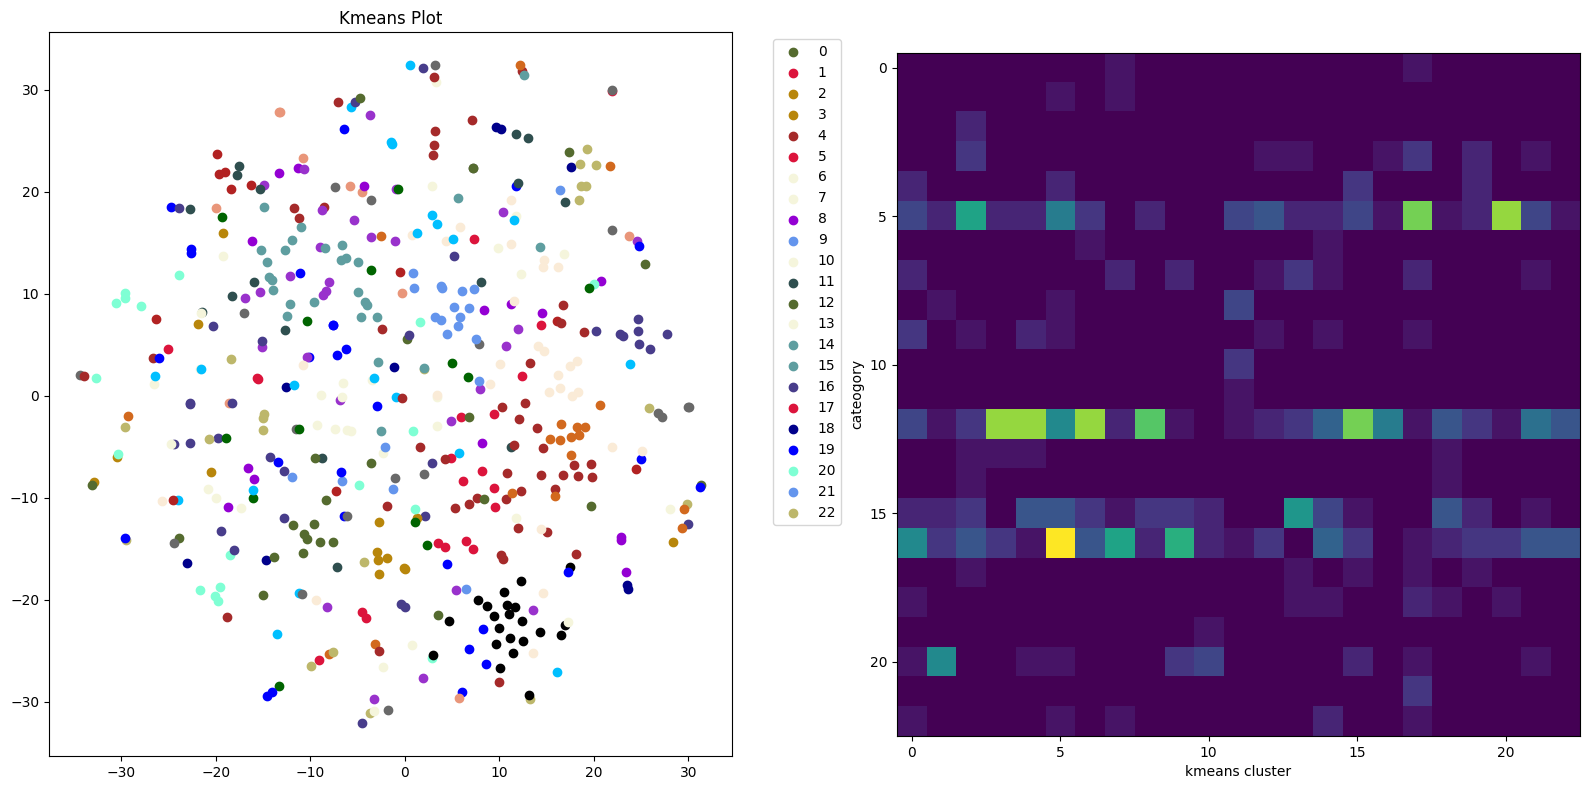

# tf-idf で k = カテゴリ数 / 2


<Figure size 640x480 with 0 Axes>

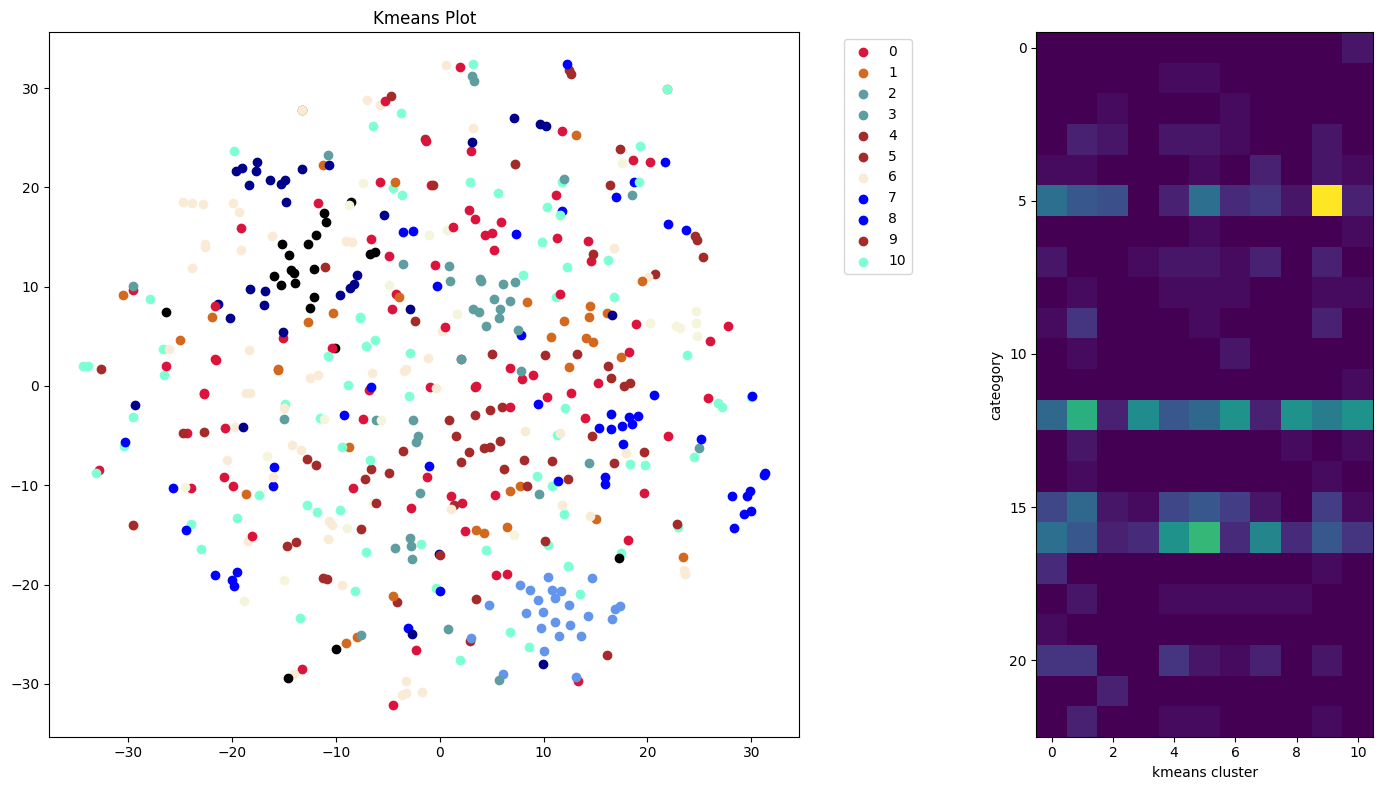

# tf-idf で k = カテゴリ数 * 2


<Figure size 640x480 with 0 Axes>

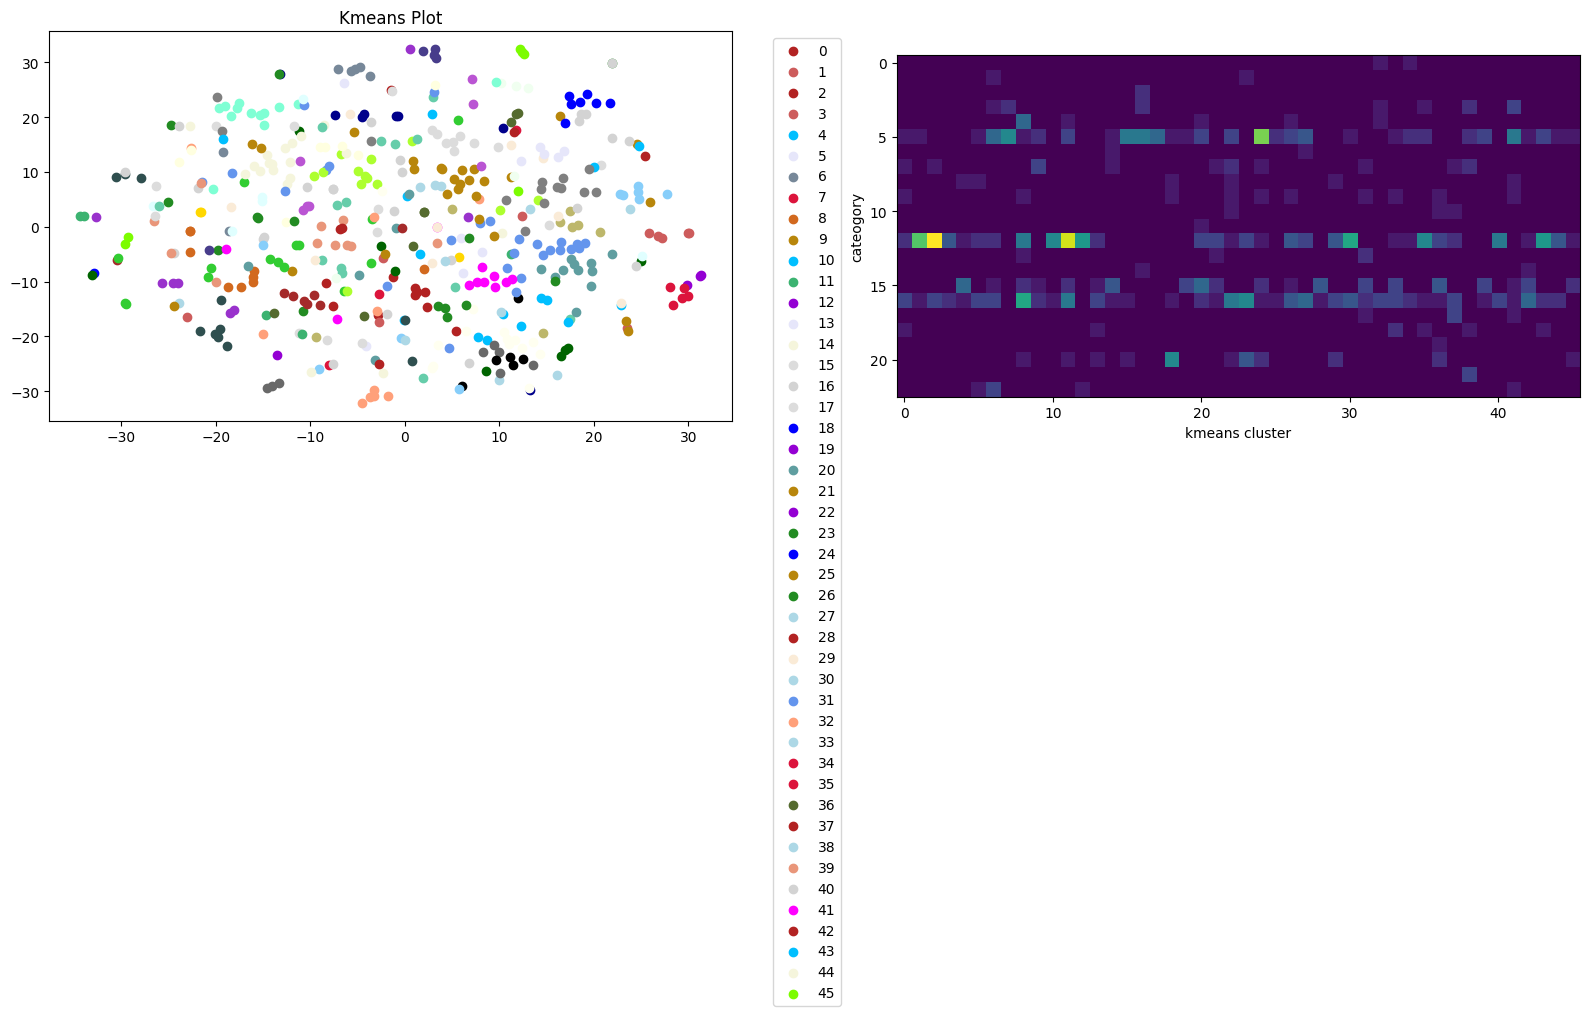

# データセットのカテゴリでプロット


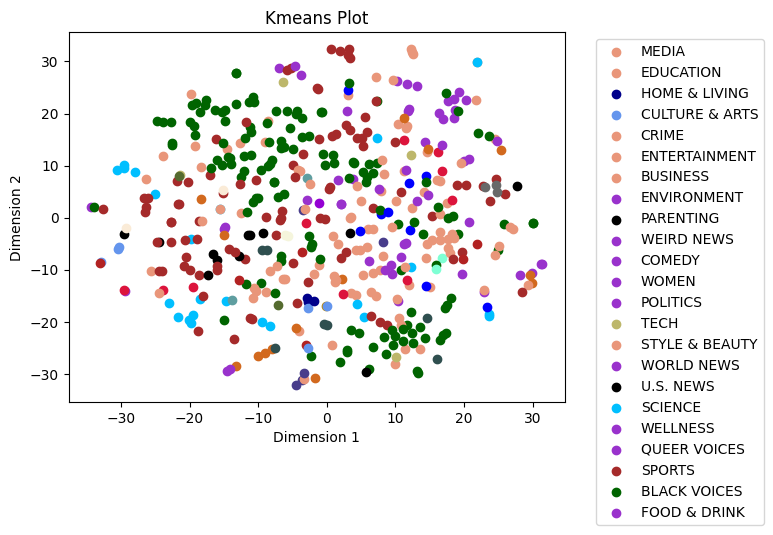

<Figure size 640x480 with 0 Axes>

In [13]:
# tf-idfのkmeans可視化
# t-SNEで2次元に次元削減
tfidf_tsne = tsne.fit_transform(tf_idf[:clus_num])

print("# tf-idf で k = カテゴリ数")
kmeans_plot(tfidf_kmeans, tfidf_tsne, colors)

print("# tf-idf で k = カテゴリ数 / 2")
kmeans_plot(tfidf_kmeans_half, tfidf_tsne, colors)

print("# tf-idf で k = カテゴリ数 * 2")
kmeans_plot(tfidf_kmeans_double, tfidf_tsne, colors)

print("# データセットのカテゴリでプロット")
class_plot(tfidf_tsne, colors)

# BoW で k = カテゴリ数


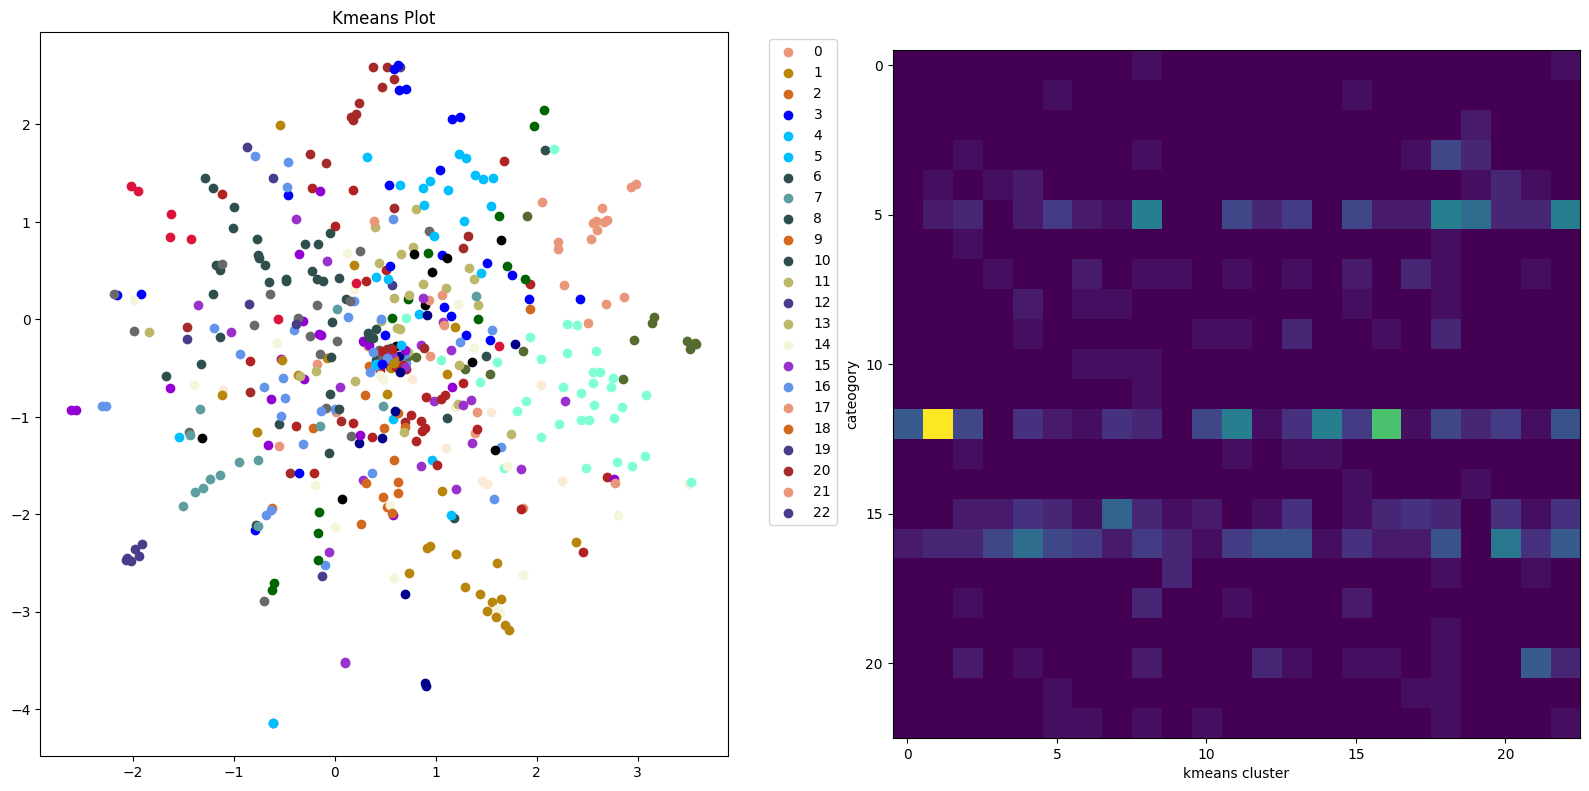

# BoW で k = カテゴリ数 / 2


<Figure size 640x480 with 0 Axes>

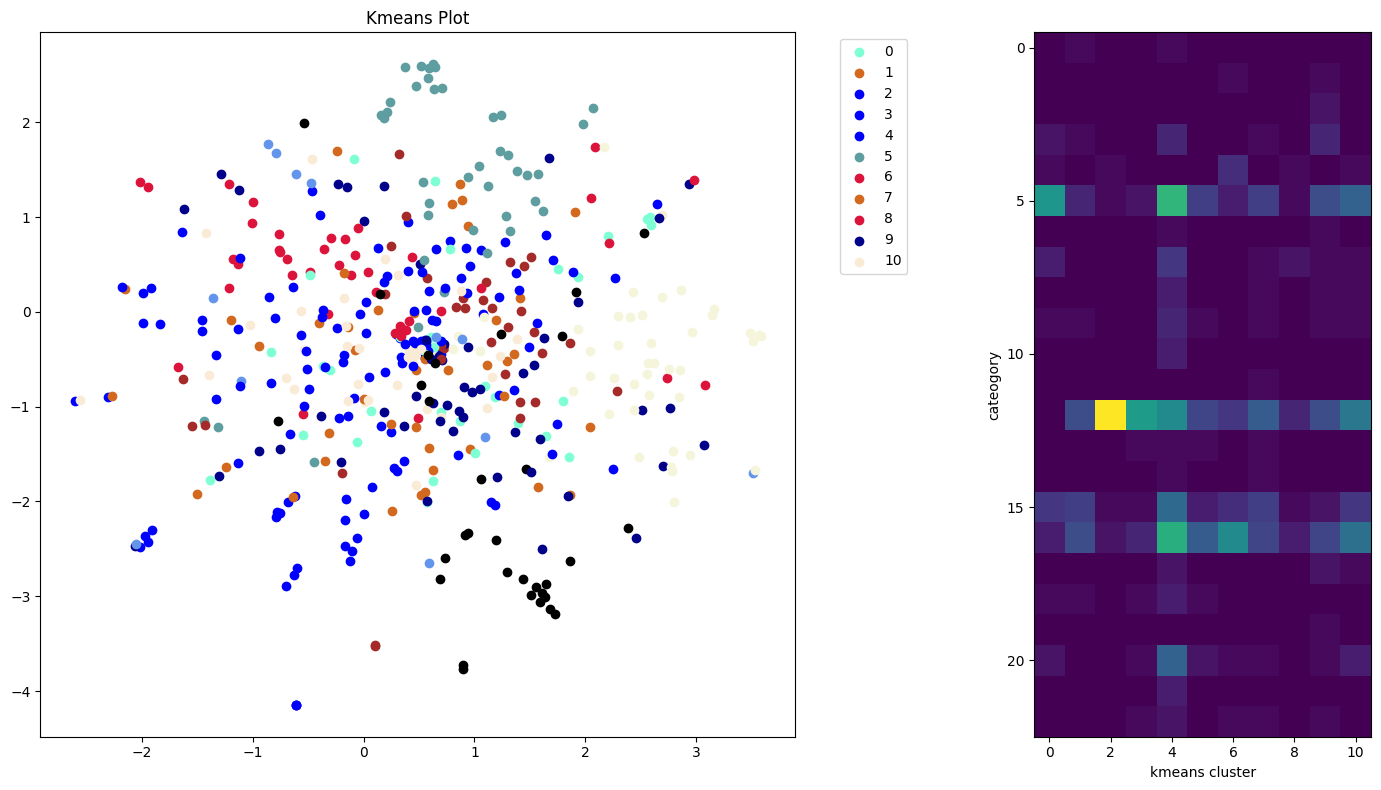

# BoW で k = カテゴリ数 * 2


<Figure size 640x480 with 0 Axes>

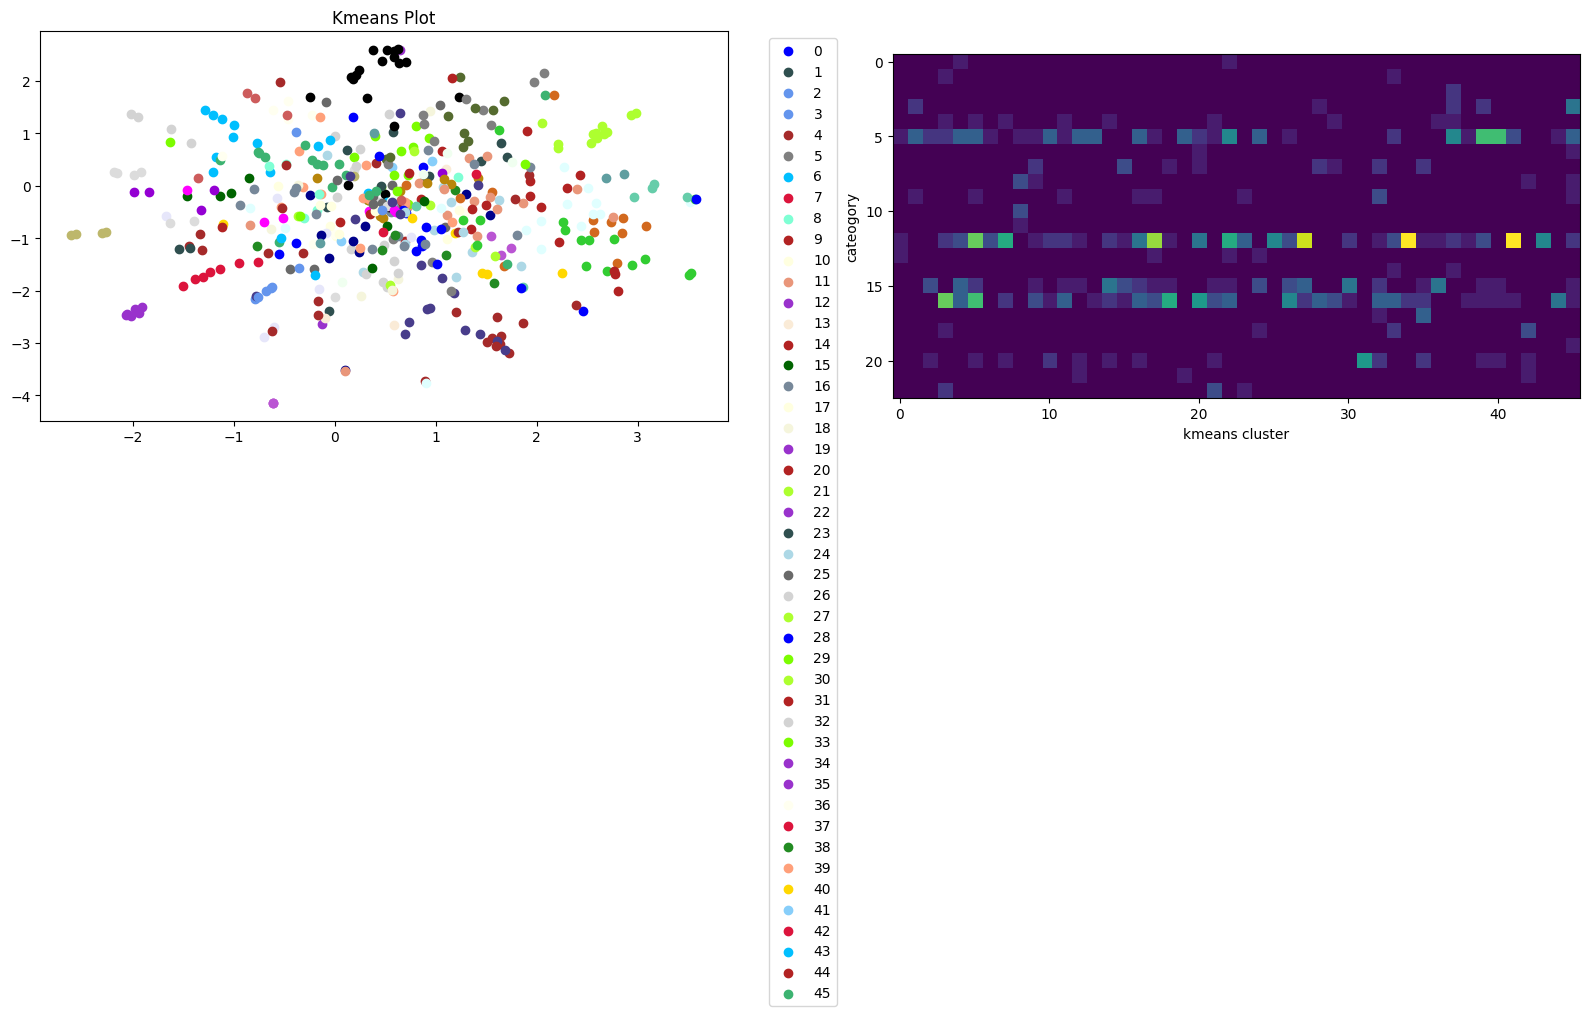

# データセットのカテゴリでプロット


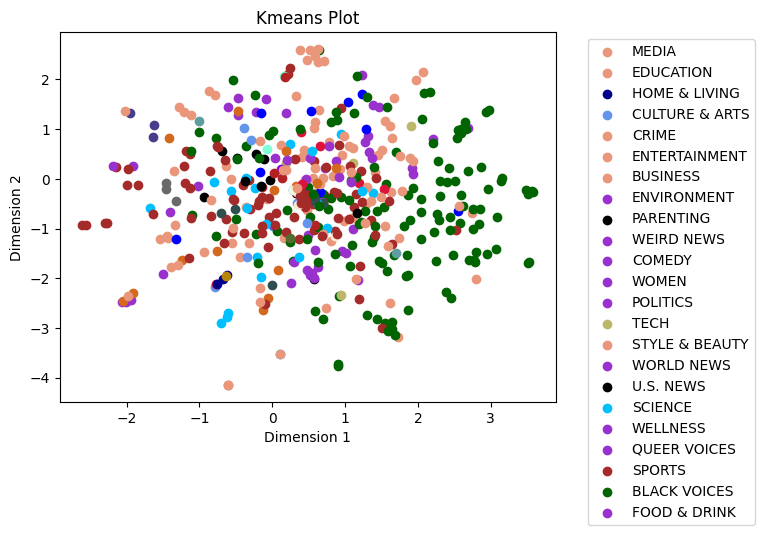

<Figure size 640x480 with 0 Axes>

In [14]:
# bowのkmeans可視化
bow_tsne = tsne.fit_transform(bow[:clus_num])

print("# BoW で k = カテゴリ数")
kmeans_plot(bow_kmeans, bow_tsne, colors)

print("# BoW で k = カテゴリ数 / 2")
kmeans_plot(bow_kmeans_half, bow_tsne, colors)

print("# BoW で k = カテゴリ数 * 2")
kmeans_plot(bow_kmeans_double, bow_tsne, colors)

print("# データセットのカテゴリでプロット")
class_plot(bow_tsne, colors)

# d2v で k = カテゴリ数


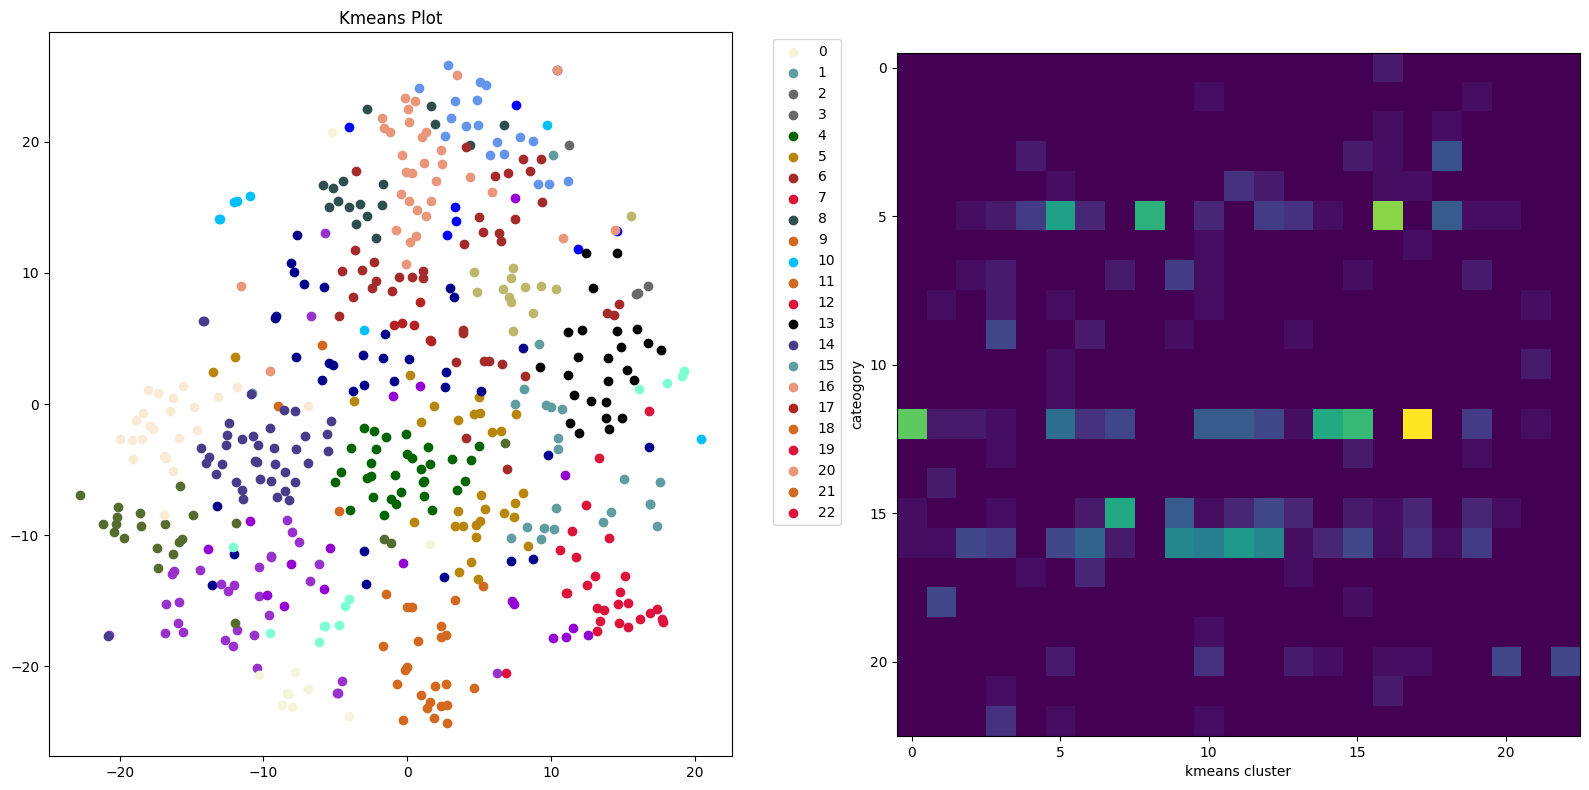

# d2v で k = カテゴリ数 / 2


<Figure size 640x480 with 0 Axes>

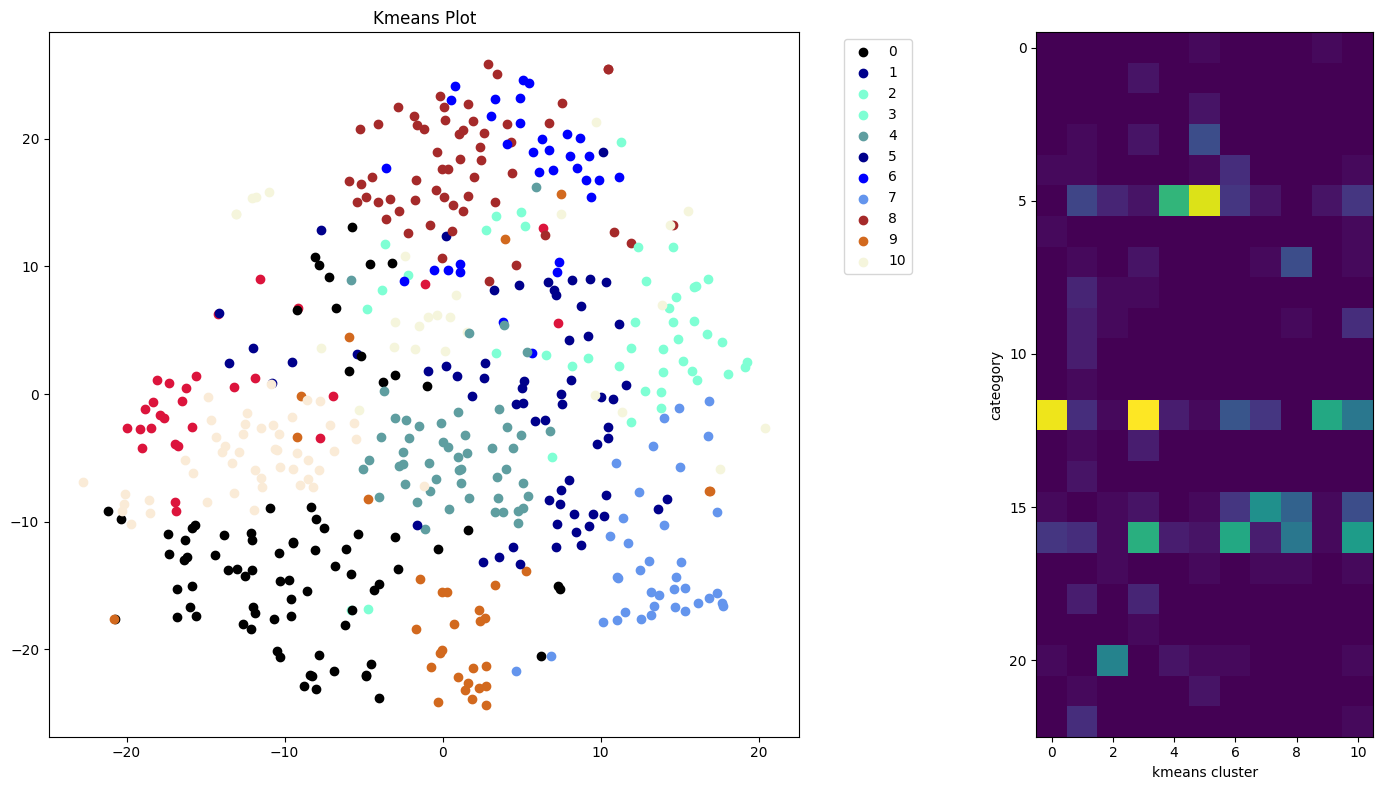

# d2v で k = カテゴリ数 * 2


<Figure size 640x480 with 0 Axes>

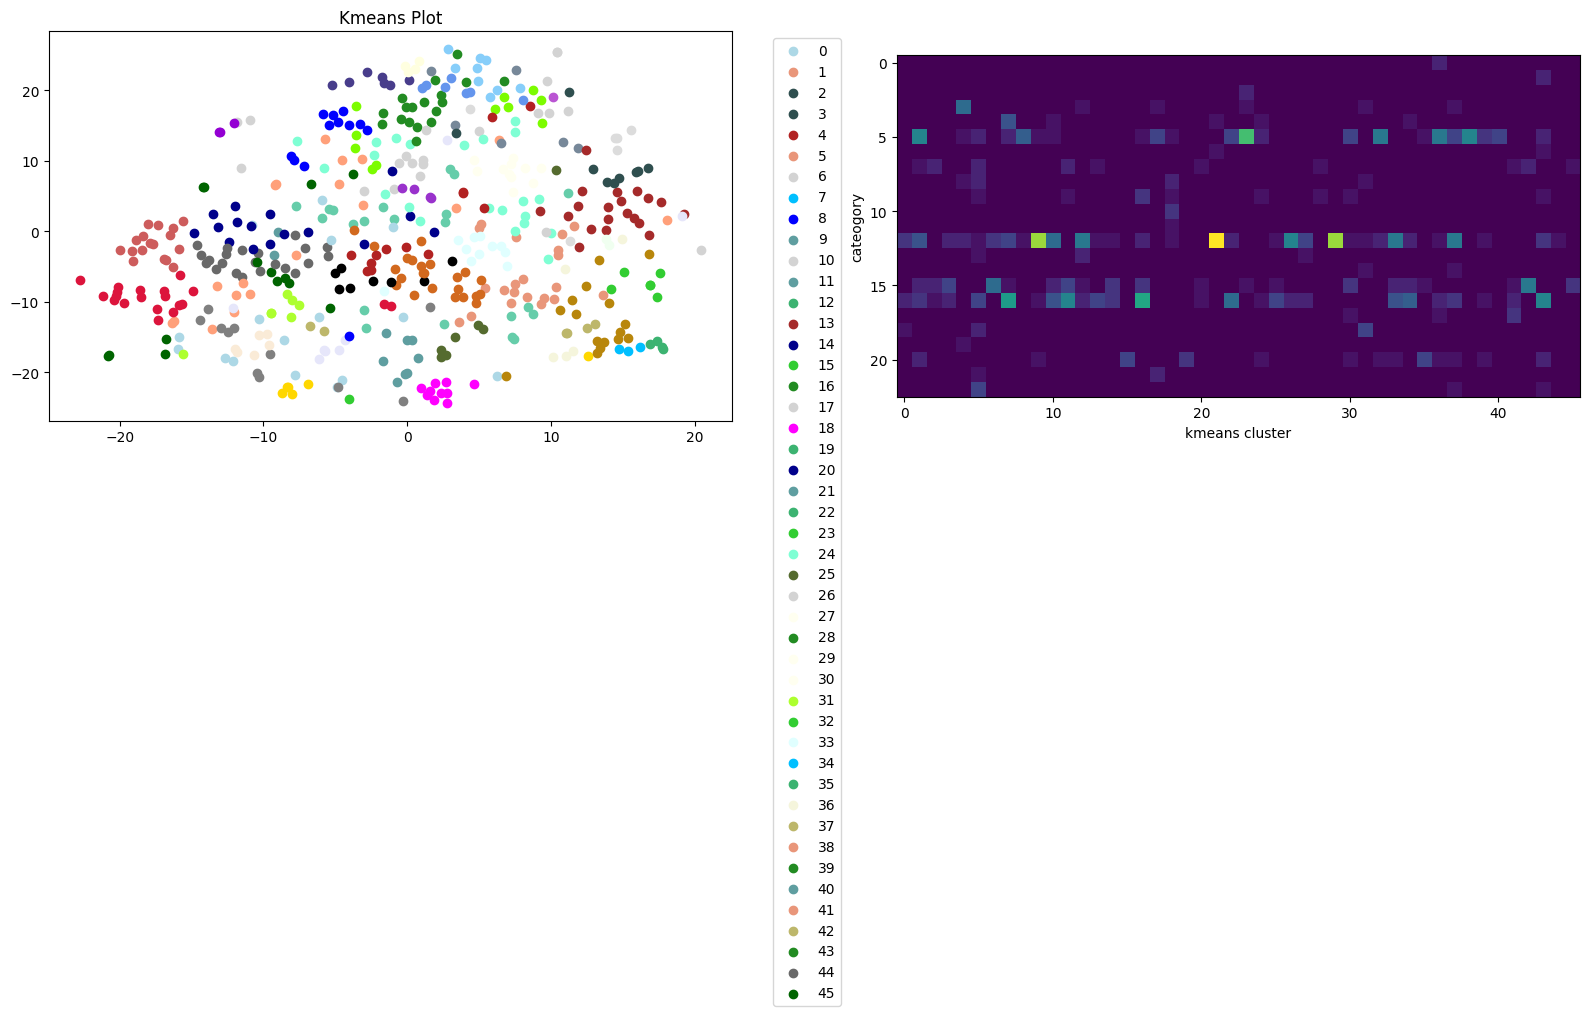

# データセットのカテゴリでプロット


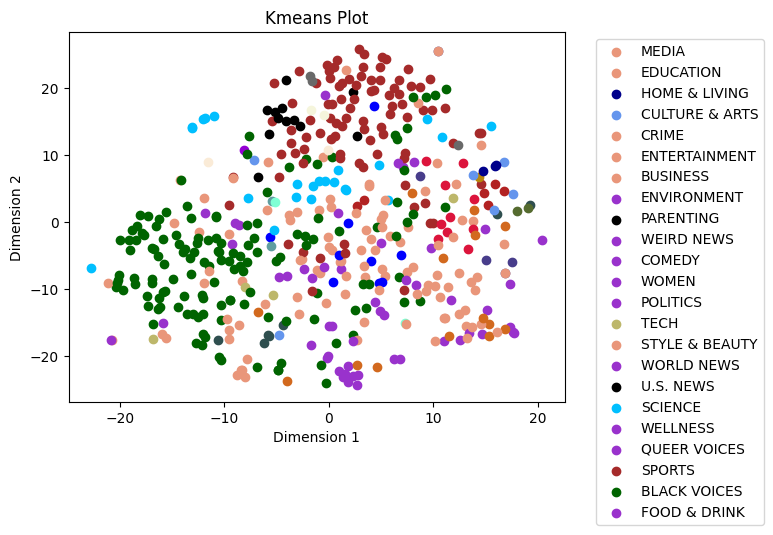

<Figure size 640x480 with 0 Axes>

In [15]:
# d2vのkmeans可視化
d2v_tsne = tsne.fit_transform(np.array(d2v[:clus_num]))

print("# d2v で k = カテゴリ数")
kmeans_plot(d2v_kmeans, d2v_tsne, colors)

print("# d2v で k = カテゴリ数 / 2")
kmeans_plot(d2v_kmeans_half, d2v_tsne, colors)

print("# d2v で k = カテゴリ数 * 2")
kmeans_plot(d2v_kmeans_double, d2v_tsne, colors)

print("# データセットのカテゴリでプロット")
class_plot(d2v_tsne, colors)